# Машинное обучение, ФЭН ВШЭ

# Практическое задание 3

## Общая информация

Дата выдачи: 29.10.2017

Срок сдачи: 23:59MSK 12.11.2017

### О задании

Практическое задание 5 посвящено использованию ядер в методах машинного обучения. В рамках данного задания вы:
 * исследуете вид разделяющих поверхностей в исходном пространстве в зависимости от типа используемов ядра и значений его параметров
 * используете SVD для сжатия картинок
 * исследуете обычный и ядровый PCA

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW3_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW3_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import ListedColormap
clr_map1 = ListedColormap(['red', 'blue'])
clr_map2 = ListedColormap(['yellow', 'green'])

## SVM

**1. (0.5 баллов)** Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно разделимыми классами;
- с хорошо разделимыми классами, но не линейно разделимыми;
- с плохо разделимыми классами.

Визуализируйте полученные выборки на плоскости.

Для генерации случайной выборки можно использовать функции из модуля [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets).

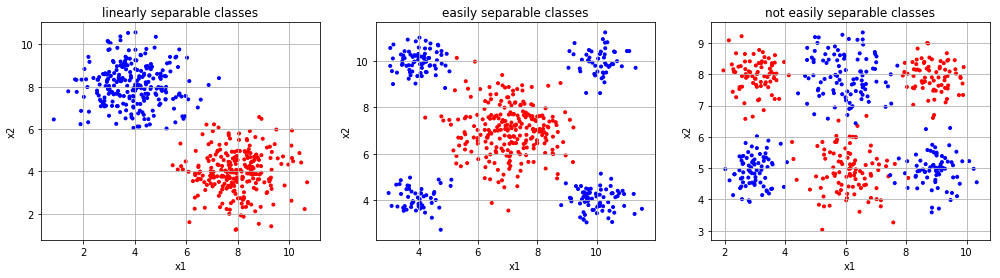

In [2]:
y = [0]*250 + [1]*250

np.random.seed(111)

plt.figure(1, figsize=[17, 4])

x1 = np.concatenate([np.random.normal(8, 1, 250), np.random.normal(4, 1, 250)])
x2 = np.concatenate([np.random.normal(4, 1, 250), np.random.normal(8, 1, 250)])

plt.subplot(1,3,1)
plt.title('linearly separable classes')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(x1, x2, marker='.', c=y, cmap=clr_map1)
plt.grid()



x3 = np.concatenate([np.random.normal(7, 1, 250), np.random.normal(10, 0.5, 50), np.random.normal(4, 0.5, 75), np.random.normal(10, 0.5, 75), np.random.normal(4, 0.5, 50)])
x4 = np.concatenate([np.random.normal(7, 1, 250), np.random.normal(10, 0.5, 50), np.random.normal(10, 0.5, 75), np.random.normal(4, 0.5, 75), np.random.normal(4, 0.5, 50)])

plt.subplot(1,3,2)
plt.title('easily separable classes')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(x3, x4, marker='.', c=y, cmap=clr_map1)
plt.grid()



x5 = np.concatenate([np.random.normal(6, 0.75, 100), np.random.normal(9, 0.5, 75), np.random.normal(3, 0.5, 75), np.random.normal(6, 0.75, 100), np.random.normal(9, 0.5, 75), np.random.normal(3, 0.5, 75)])
x6 = np.concatenate([np.random.normal(5, 0.75, 100), np.random.normal(8, 0.5, 75), np.random.normal(8, 0.5, 75), np.random.normal(8, 0.75, 100), np.random.normal(5, 0.5, 75), np.random.normal(5, 0.5, 75)])

plt.subplot(1,3,3)
plt.title('not easily separable classes')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(x5, x6, marker='.', c=y, cmap=clr_map1)
plt.grid()

plt.show()

Рассмотрим (https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture13-features.pdf) двойственную задачу метода опорных векторов:
$$\begin{cases}
\sum_{i=1}^l \lambda_i - \frac{1}{2} \sum_{i, \, j =1}^l \lambda_i \lambda_j y_i y_j \langle x_i, x_j\rangle \to \max_\lambda,\\
0 \le \lambda_i \le C, i = \overline{1, l},\\
\sum_{i=1}^l \lambda_i y_i = 0.
\end{cases}$$

После решения данной задачи прогнозы для новых объектов строятся следующим образом: $a(x) = \text{sign} \left( \sum_{i=1}^l \lambda_i y_i \langle x_i, x \rangle + b \right).$

Заметим, что и оптимизационная задача, и формула итогового классификатора зависят лишь от скалярных произведений объектов, а потому в данном методе можно использовать ядра для восстановления нелинейных зависимостей.

**2. (1.5 балла)** Обучите на сгенерированных ранее двумерных выборках [ядровой SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) с использованием следующих типов ядер (для различных значений гиперпараметра $C$):
- линейное: $K(x, z) = \langle x, z \rangle$;
- полиномиальное: $K(x, z) = (\gamma \langle x, z \rangle + 1)^d$ (для различных значений $\gamma, d$);
- гауссовское: $K(x, z) = \exp(-\gamma \|x - z\|^2)$ (для различных значений $\gamma$).

Визуализируйте разделяющую поверхность и разделяющую полосу:
 - для модели с линейным ядром для различных значений $C$;
 - для моделей, использующих полиномиальное и гауссовское ядро, соответствующих недообучению, нормальному поведению и переобучению.

In [3]:
from sklearn.svm import SVC

### Линейное ядро

In [4]:
def plot_lin_svm(x1, x2, c, bounds):
    
    plt.figure(1, figsize=[17, 4])
    
    for i in range(len(c)):
        plt.subplot(1,3,i+1)

        svm = SVC(kernel='linear', C=c[i])
        svm.fit(np.array([x1,x2]).T, y)
        w0, w1, w2 = svm.intercept_, svm.coef_[0,0], svm.coef_[0,1]

        f_x = lambda x : (-w1/w2)*x - w0/w2

        xx = np.linspace(bounds[0], bounds[1], 100)

        plt.title('C = ' + str(c[i]))
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.scatter(x1, x2, marker='.', c=y, cmap=clr_map1)
        plt.grid()

        plt.plot(xx, f_x(xx), color='black', lw=2)
        
        sv1 = svm.support_vectors_[0]
        b1 = sv1[1] - f_x(sv1[0])
        sv2 = svm.support_vectors_[-1]
        b2 = sv2[1] - f_x(sv2[0])
        plt.plot(xx, f_x(xx) + b1, color='black', linestyle='--', lw=1)
        plt.plot(xx, f_x(xx) + b2, color='black', linestyle='--', lw=1)
        
        plt.ylim(bounds)
    
    plt.show()


##### Линейно разделимые классы

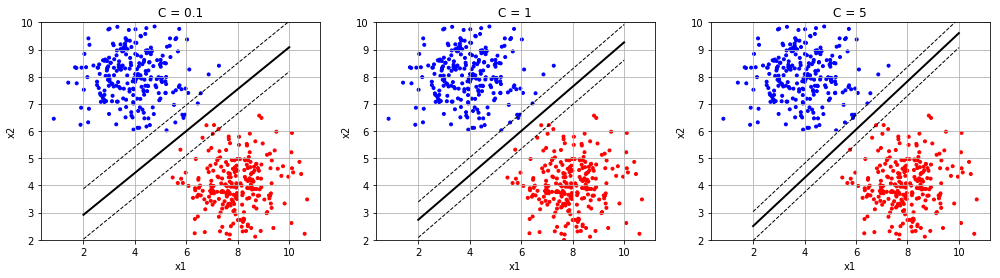

In [5]:
plot_lin_svm(x1, x2, c=[0.1, 1, 5], bounds=[2, 10])

Хорошо видно, как при увеличении С сужается разделяющая полоса.

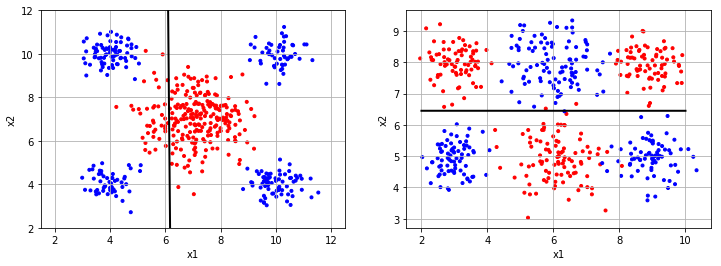

In [6]:
plt.figure(1, figsize=[12, 4])
    
plt.subplot(1,2,1)

svm = SVC(kernel='linear', C=1)
svm.fit(np.array([x3,x4]).T, y)
w0, w1, w2 = svm.intercept_, svm.coef_[0,0], svm.coef_[0,1]

f_x = lambda x : (-w1/w2)*x - w0/w2

xx = np.linspace(2, 12, 100)

plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(x3, x4, marker='.', c=y, cmap=clr_map1)
plt.grid()

plt.ylim([2, 12])

plt.plot(xx, f_x(xx), color='black', lw=2)

plt.subplot(1,2,2)

svm = SVC(kernel='linear', C=1)
svm.fit(np.array([x5,x6]).T, y)
w0, w1, w2 = svm.intercept_, svm.coef_[0,0], svm.coef_[0,1]

f_x = lambda x : (-w1/w2)*x - w0/w2

xx = np.linspace(2, 10, 100)

plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(x5, x6, marker='.', c=y, cmap=clr_map1)
plt.grid()

plt.plot(xx, f_x(xx), color='black', lw=2)

plt.show()

Для других выборок использование линейного ядра бессмысленно.

### Полиномиальное ядро

In [7]:
def plot_poly_svm(x1, x2, c, degree, gamma, x1_bounds, x2_bounds):
    plt.figure(1, figsize=[17, 4])
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        svm = SVC(kernel='poly', C=c[i], degree=degree[i], gamma=gamma[i])
        svm.fit(np.array([x1,x2]).T, y)

        step = 0.02
        x1_min, x1_max = x1_bounds[0], x1_bounds[1]
        x2_min, x2_max = x2_bounds[0], x2_bounds[1]
        xx, yy = np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step))

        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=clr_map2)
        plt.scatter(x1, x2, c=y, s=10, cmap=clr_map1)
        
        plt.title('degree = ' + str(degree[i]))
        plt.xlabel('x1')
        plt.ylabel('x2')

    
    plt.show()

##### Линейно разделимые классы

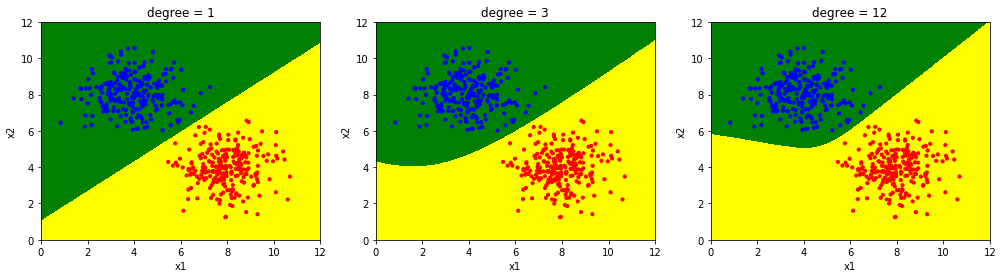

In [8]:
plot_poly_svm(x1, x2, c=[1,1,1], degree=[1,3,12], gamma=[1,1,1], x1_bounds=[0,12], x2_bounds=[0,12])

С линейно разделимыми классами любая модель с полиномиальным ядром работает достаточно хорошо, хотя при выских степенях наблюдается некоторое переобучение.

##### Хорошо разделимые классы

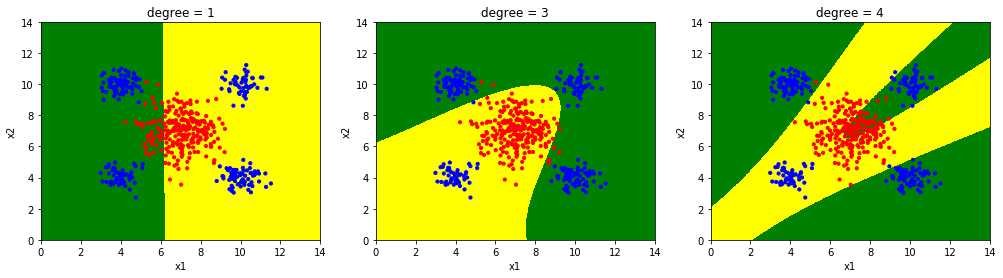

In [9]:
plot_poly_svm(x3, x4, c=[1,1,1], degree=[1,3,4], gamma=[1,1,1], x1_bounds=[0,14], x2_bounds=[0,14])

Модель со степенью 1 недообучена (потому что она линейная), модель со степенью 3 выдает наилучший результат, на который способно полиномиальное ядро при таких данных, модель со степенью 5 переобучена.

##### Плохо разделимые классы

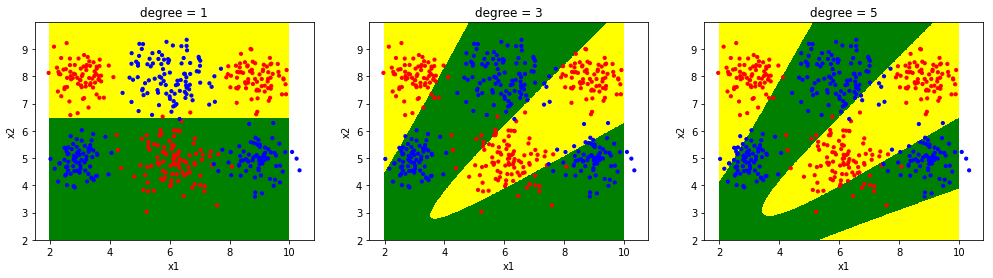

In [10]:
plot_poly_svm(x5, x6, c=[1,1,1], degree=[1,3,5], gamma=[1,1,1], x1_bounds=[2,10], x2_bounds=[2,10])

Модель со степенью 1 недообучена (потому что она линейная), модели со степенями 3 и 5 выдают адекватный для полиномиального ядра результат.

### Гауссовское ядро

In [11]:
def plot_rbf_svm(x1, x2, c, gamma, x1_bounds, x2_bounds):
    plt.figure(1, figsize=[17, 4])
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        svm = SVC(kernel='rbf', C=c[i], gamma=gamma[i])
        svm.fit(np.array([x1,x2]).T, y)

        step = 0.02
        x1_min, x1_max = x1_bounds[0], x1_bounds[1]
        x2_min, x2_max = x2_bounds[0], x2_bounds[1]
        xx, yy = np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step))

        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=clr_map2)
        plt.scatter(x1, x2, c=y, s=10, cmap=clr_map1)
        
        plt.title('gamma = ' + str(gamma[i]))
        plt.xlabel('x1')
        plt.ylabel('x2')

    
    plt.show()

##### Линейно разделимые классы

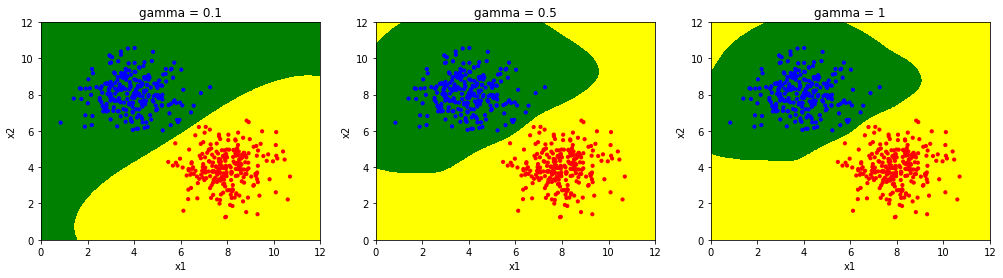

In [12]:
plot_rbf_svm(x1, x2, c=[1,1,1], gamma=[0.1,0.5,1], x1_bounds=[0,12], x2_bounds=[0,12])

С линейно разделимыми классами любая модель с гауссовским ядром работает хорошо.

##### Хорошо разделимые классы

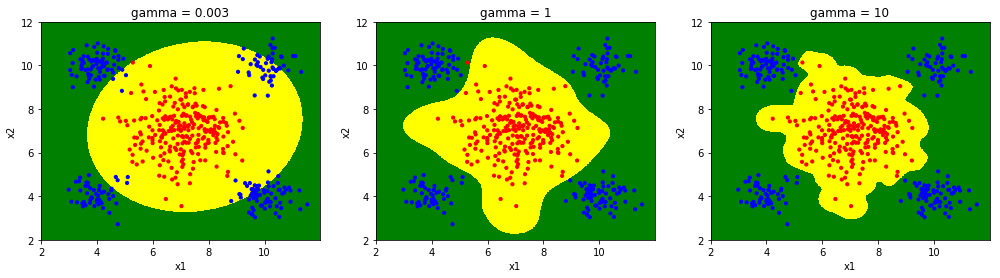

In [13]:
plot_rbf_svm(x3, x4, c=[1,1,1], gamma=[0.003,1,10], x1_bounds=[2,12], x2_bounds=[2,12])

Первая модель недообучена, вторая адекватна данным, третья переобучена.

##### Плохо разделимые классы

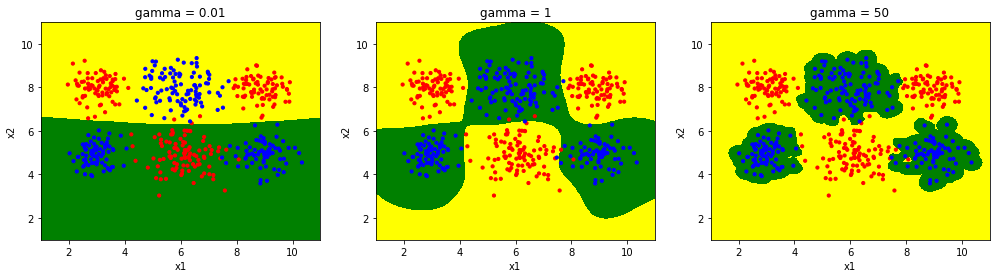

In [14]:
plot_rbf_svm(x5, x6, c=[1,1,1], gamma=[0.01,1,50], x1_bounds=[1,11], x2_bounds=[1,11])

Первая модель недообучена, вторая адекватна данным, третья сильно переобучена.

**3. (1 балл)** Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от значений гиперпараметра $C$, степени ядра $d$ и параметра $\gamma$?
 - Как ведет себя SVM с гауссовским ядром в зависимости от значений гиперпараметра $C$ и $\gamma$?

Для полиномиального ядра: увеличени С сужает разделяющую полосу, изменение степени ядра меняет форму разделяющей поверхности в исходном пространстве на полином соответствующей степени, увеличение гаммы усложняет форму разделяющей поверхности в рамках выбранной степени.

Для гауссовского ядра: увеличени С сужает разделяющую полосу, увеличение гаммы усложняет форму разделяющей поверхности и приводит к большему подстраиванию под данные.

**4. (1.5 балл)** Обучите модели с использованием ядер из п. 2 для задачи бинарной классификации [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (используйте файл train.csv) для значения $C=1.$ Для оценки качества разбейте выборку на обучающую и тестовую в отношении 50/50. Постройте модель, позволяющую достичь значения accuracy, равного 0.75, на тестовой выборке. Позволяет ли использование ядер достичь лучшего качества по сравнению с линейной моделью?

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [16]:
df = pd.read_csv('train.csv')
y = np.array(df['Activity'])
x = np.array(df.drop('Activity', axis=1))
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.5, random_state=71)

C:\Users\Oleg\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
print('C=1:')
print('Линейное ядро, accuracy =', accuracy_score(y_test, SVC(kernel='linear', C=1).fit(x_train, y_train).predict(x_test)))
print('Полиномиальное ядро, accuracy =', accuracy_score(y_test, SVC(kernel='poly', C=1).fit(x_train, y_train).predict(x_test)))
print('Гауссовское ядро, accuracy =', accuracy_score(y_test, SVC(kernel='rbf', C=1).fit(x_train, y_train).predict(x_test)))

C=1:
Линейное ядро, accuracy = 0.721748400853
Полиномиальное ядро, accuracy = 0.544776119403
Гауссовское ядро, accuracy = 0.691364605544


Без настройки гиперпараметров линейное ядро дает наилучший результат. А если их настроить, то с линейным ядром даже можно достичь accuracy 0.75:

In [18]:
print('Линейное ядро, C=0.1, accuracy =', accuracy_score(y_test, SVC(kernel='linear', C=0.1).fit(x_train, y_train).predict(x_test)))

Линейное ядро, C=0.1, accuracy = 0.750533049041


Но с гауссовским ядром можно получить результат еще лучше:

In [19]:
print('Гауссовское ядро, C=10, gamma=0.01, accuracy=', accuracy_score(y_test, SVC(kernel='rbf', C=10, gamma=0.01).fit(x_train, y_train).predict(x_test)))

Гауссовское ядро, C=10, gamma=0.01, accuracy= 0.763326226013


## SVD

Скачайте картинку и положите в каталог рядом с ноутбуком:

In [2]:
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
import sys
%matplotlib inline

img = misc.imread(r'art.jpg')

C:\Users\Oleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


Посмотрим на нее:

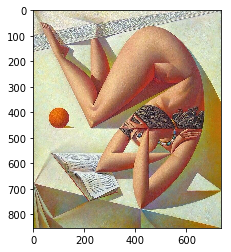

In [21]:
plt.imshow(img);

Для удобства оставим только один канал.

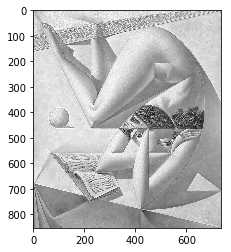

In [3]:
img = img[:,:,0]
plt.imshow(img, cmap='gray');

**5. (1 балла)** 

Главные компоненты - это матрицы вида  $u_i\sigma_iv_i^T$, где  $u_i, v_i$ это столбцы матриц $U$ и $V$ из сингулярного разложения; $\sigma_i$ соответсвующее сингулярное число. Визуализуйте первые и последние несколько компонент. Сделайте выводы.

In [4]:
from sklearn.decomposition import PCA

In [5]:
img_centered = img - img.mean(axis=0)

Первые 10 компонент:


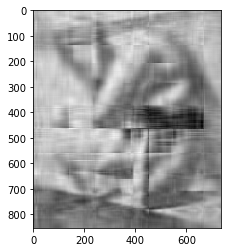

In [6]:
print('Первые 10 компонент:')

pca = PCA(n_components=10)
pca.fit(img_centered)
img_pca = pca.transform(img_centered)

compressed_img = np.dot(img_pca, pca.components_) + img.mean(axis=0)
plt.imshow(compressed_img, cmap='gray')
plt.show()

Последние 10 компонент:


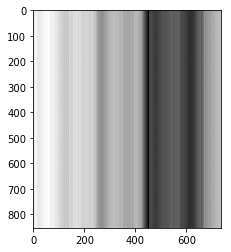

In [7]:
print('Последние 10 компонент:')

pca = PCA(n_components=None)
pca.fit(img_centered)
components = pca.components_[-10:]
img_pca = np.dot(img_centered, components.T)

compressed_img = np.dot(img_pca, components) + img.mean(axis=0)
plt.imshow(compressed_img, cmap='gray')
plt.show()

Первые 10 компонент позволяют восстановить общие очертания изображения. Последние компоненты, вполне предсказуемо, почти не содержат полезной информации.

**6. (1 балл)** 

Как вам кажется, сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения? Используйте график объясненной дисперсии для вашего выбора. Покажите полученные картинки для разного числа компонент.  Во сколько раз меньше памяти потребуется для хранения?  Вес объекта можно узнат командой * sys.getsizeof(x) *


In [8]:
pca = PCA(n_components=None)
pca.fit(img_centered)

explained_var = [sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_))]

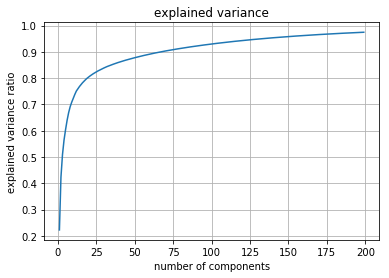

In [9]:
plt.plot(range(1, 200), explained_var[:199], '-')
plt.grid()
plt.title('explained variance')
plt.xlabel('number of components')
plt.ylabel('explained variance ratio')
plt.show()

75 первых компонент объясняют более 90% дисперсии и, скорее всего, их будет достаточно для хорошего восстановления исходного изображения.

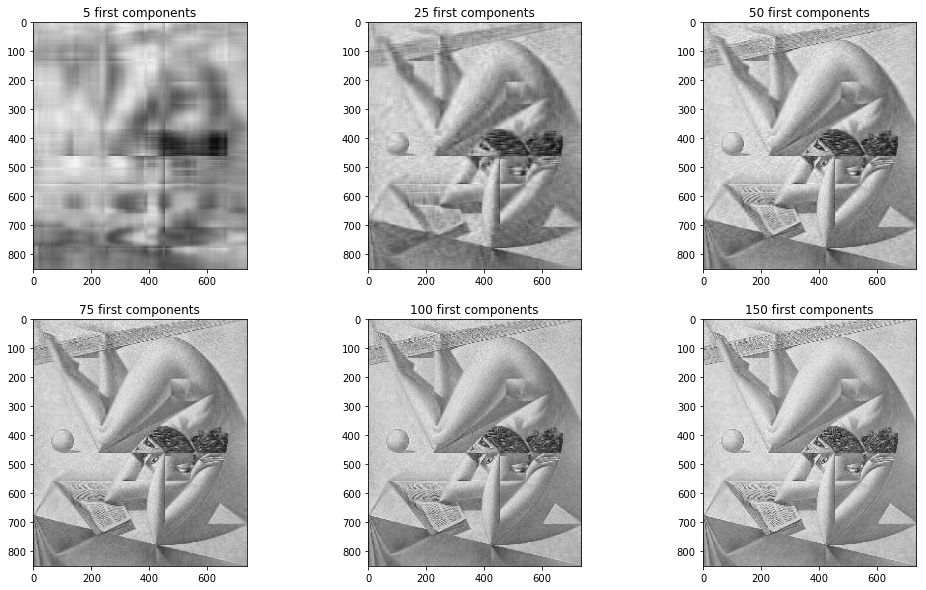

In [10]:
plt.figure(1, figsize=[17, 10])
n_components = [5, 25, 50, 75, 100, 150]

for i in range(0,6):
    plt.subplot(2,3,i+1)
    components = pca.components_[:n_components[i]]
    img_pca = np.dot(img_centered, components.T)
    compressed_img = np.dot(img_pca, components) + img.mean(axis=0)
    plt.title(str(n_components[i]) + ' first components')
    plt.imshow(compressed_img, cmap='gray')

plt.show()

Видно, что уже 50 компонент позволяют очень хорошо восстановить изображение.

Чтобы уменьшить количество необходимой для хранения памяти, придется хранить картинку в виде отдельных векторов.

In [11]:
from scipy.linalg import svd
U, S, V = np.linalg.svd(img_centered, compute_uv=True)

In [15]:
print('Вес исходного изображения:', img.astype('float64').nbytes)
print('Вес изображения из первых 50 компонент:', U[:,:50].nbytes + V[:50,:].nbytes + S[:50].nbytes)

Вес исходного изображения: 5022464
Вес изображения из первых 50 компонент: 636000


Вес изображения уменьшился почти в 8 раз.

## PCA

Рассмотрим нелиненый датасет. Попробуем решить задачу классификации, используя представление точек, полученнуе с помощью различных версий PCA.

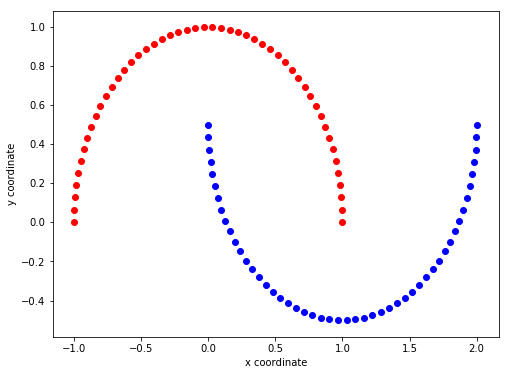

In [32]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=654)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

### Linear PCA

**7. (1 балл)** 

Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. 


In [33]:
X_centered = X - X.mean(axis=0)

Проекция на одну компоненту:


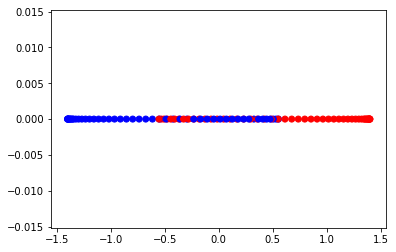

In [34]:
print('Проекция на одну компоненту:')
pca = PCA(n_components=1)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)
plt.scatter(X_pca, [0]*100, c=y, cmap=clr_map1)
plt.show()

Проекция на две компоненты:


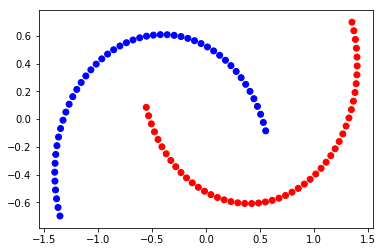

In [35]:
print('Проекция на две компоненты:')
pca = PCA(n_components=2)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap=clr_map1)
plt.show()

### RBF PCA

**8. (0.5 балла)** 
Допишите в месте "Your code here" построение матрицы ~~Грамма~~ <span style="color:red">Грама</span> для RBF ядра, с параметром gamma. Обратите внимание, что выше в коде уже получена матрица попарных расстояний ~~sq_dists~~ <span style="color:red">mat_sq_dists</span>.

In [36]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

In [37]:
def stepwise_kpca(X, gamma, n_components):
    """
    X: A MxN dataset as NumPy array where the samples are stored as rows (M), features as columns (N).
    gamma: coefficient for the RBF kernel.
    n_components: number of components to be returned.

    """
    # Calculating the squared Euclidean distances for every pair of points
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)

    K = exp(-gamma*mat_sq_dists)

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))

    return X_pc

**9. (2 балл)**  
Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. Подберите такой параметр gamma, что выборка стала линейно разделимой.

Проекция на одну компоненту, gamma=5, выборка неразделима:


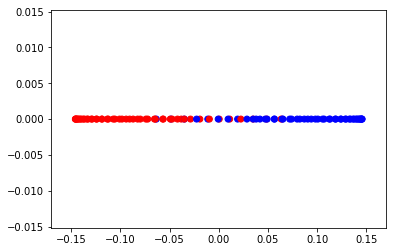

In [38]:
print('Проекция на одну компоненту, gamma=5, выборка неразделима:')
X_pca_rbf = stepwise_kpca(X_centered, gamma=5, n_components=1)
plt.scatter(X_pca_rbf, [0]*100, c=y, cmap=clr_map1)
plt.show()

Проекция на одну компоненту, gamma=15, выборка линейно разделима:


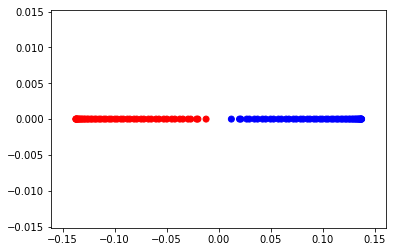

In [39]:
print('Проекция на одну компоненту, gamma=15, выборка линейно разделима:')
X_pca_rbf = stepwise_kpca(X_centered, gamma=15, n_components=1)
plt.scatter(X_pca_rbf, [0]*100, c=y, cmap=clr_map1)
plt.show()

Проекция на две компоненты, gamma=5, выборка неразделима:


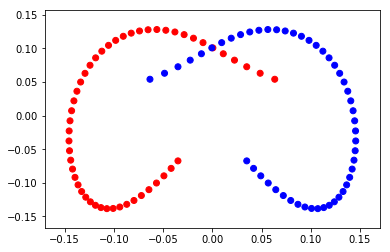

In [40]:
print('Проекция на две компоненты, gamma=5, выборка неразделима:')
X_pca_rbf = stepwise_kpca(X_centered, gamma=5, n_components=2)
plt.scatter(X_pca_rbf[:,0], X_pca_rbf[:,1], c=y, cmap=clr_map1)
plt.show()

Проекция на две компоненты, gamma=15, выборка линейно разделима:


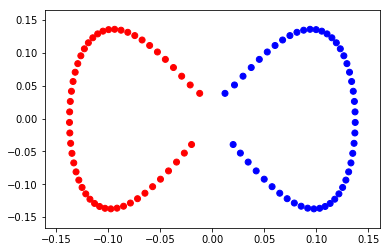

In [41]:
print('Проекция на две компоненты, gamma=15, выборка линейно разделима:')
X_pca_rbf = stepwise_kpca(X_centered, gamma=15, n_components=2)
plt.scatter(X_pca_rbf[:,0], X_pca_rbf[:,1], c=y, cmap=clr_map1)
plt.show()

### Ваши мысли о задании:

### Здесь можете поделиться картинкой